# Step5 演習05 Sequence-to-Sequenceモデル
---

本演習では、Sequence-to-Sequenceモデルをスクラッチで実装し、足し算を答えるモデルを作成します。

**はじめに**
- for文やwhile文の利用は明示的な利用指示がない場所での利用は避けてください。

**本演習の目的**
- Sequence-to-Sequenceモデルをnumpyのみで実装する

## ライブラリのインストール

まずはじめに、本演習で利用するライブラリのインポートを行います。

- [numpy](http://www.numpy.org) 数値計算を行うための基本パッケージの公式ドキュメント
- [matplotlib](http://matplotlib.org) グラフ描画ライブラリの基本パッケージの公式ドキュメント


`%matplotlib inline` はnotebook上で使える[magic function](http://ipython.readthedocs.io/en/stable/interactive/magics.html)の一つで、これによりmatplotlibをインタラクティブに使うことできます。

In [1]:
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt

## データセット

**【課題１】**　ここでは、任意の桁数が与えられた時に、その桁数以下のランダムな数字（整数）を返す関数を実装します。

まずは簡単な課題からです。`get_number`は`digits`(桁）が引数としてあります。この関数内で`out`が最小０、最大`digits`桁のランダムな数字を取るように実装してください。例えばdigits=3の場合`out`は0~999の間の数字となります。

In [2]:
#Coursedele-02 Step5 QuestionNumber14 405ee191fa975579113371fb2d1eccb0
def get_number(digits):
    ###############START CODE HERE###############
    out = np.random.randint(0, 10 ** digits)
    ################END CODE HERE################
    return out

** ファイルを保存後 **、次のセルを実行（Shift+Enter）で採点を行います。

In [3]:
%%bash
./validation_client.py dele-02 5 14 Step5_05.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



In [4]:
np.random.seed(1234)
digits_ = 3
get_number(digits_)

815

**Expected Output**: 
<table style = "width:40%">
    <tr>
    <td>** get\_number(digits_) **</td> 
        <td>815</td> 
    </tr>

</table>

**【課題２】** 入力と出力の長さを揃えるための関数を実装します。

ここでは、数字を文字列に変換して、RNNの入出力とします。例えば入力が"23+100"の時出力は"123"となります。RNNの入出力のサイズは可変なのですが、ミニバッチを使って効率よく学習する場合はサイズを固定するのが一般的です。そこで、入力サイズと出力サイズを固定します。この演習では最大3桁の数字の扱うので、入力サイズは最大"7"(eg.100+100)、出力サイズは最大"4"(eg.1000)となるので、すべてこのサイズになるように調整します。

関数`def padding`は2つの引数があります。
- x: 入力文字列（eg.'100+100', 1000)
- length: 固定するサイズ

この関数内では、入力文字列のサイズが固定するサイズ未満の時は文字列の最後に半角スペース' 'を追加します。

In [5]:
#Coursedele-02 Step5 QuestionNumber15 0f1bdb874e36aa8f2cb821fd143bc096
def padding(x, length):
    ###############START CODE HERE###############
    out = x + ' ' * (length - len(x))
    ################END CODE HERE################
    return out

** ファイルを保存後 **、次のセルを実行（Shift+Enter）で採点を行います。

In [6]:
%%bash
./validation_client.py dele-02 5 15 Step5_05.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



In [7]:
tin = '23+100'
tout = '123'
print(padding(tin, 7))
print(padding(tout, 4))

23+100 
123 


**Expected Output**: 
<table style = "width:40%">
    <tr>
    <td>** print(padding(tin, 7)) **</td> 
     <td>23+100&nbsp;</td> 
    </tr>
        <tr>
    <td>** print(padding(tout, 4))**</td> 
     <td>120&nbsp;</td> 
    </tr>
</table>

※入力文字列のサイズが固定するサイズ未満のときは文字列の最後に半角スペース' 'が追加されていることに注意してください。

教師強制の時と同様に文字列のままだとRNNは扱えないので数値化する必要があります。そこで教師強制時と同様に文字列を数値化する辞書と、数値から文字列に変換する辞書を作成します。

In [8]:
# この演習で扱う12文字
chars = '0123456789+ '
char2ix = {ch:i for i,ch in enumerate(chars)}
ix2char = {i:ch for i,ch in enumerate(chars)}

以上の関数を使ってデータセットをまず作成します。

In [9]:
def get_dataset(data_size):
    # データセットの配列を作成
    X = np.zeros((data_size, 7, 12))
    Y = np.zeros((data_size, 4, 12))
    for i in range(data_size):
        # 最大3桁の2つの数字を生成
        a, b = get_number(3), get_number(3)
        # 入力データの生成
        text_in = '{}+{}'.format(a, b)
        # 出力データの生成
        text_out = str(a+b)
        # サイズを揃える
        text_in = padding(text_in, 7)
        text_out = padding(text_out, 4)
        # 文字列を数値化して、更にone-hotベクトル化
        for j, ch_in  in enumerate(text_in):
            X[i, j, char2ix[ch_in]] = 1
        for j, ch_out in enumerate(text_out):
            Y[i, j, char2ix[ch_out]] = 1
    return X, Y

In [10]:
data_size = 15000
X, Y = get_dataset(data_size)
train_split = int(data_size*0.8)
X_train, Y_train = X[:train_split], Y[:train_split]
X_test, Y_test = X[train_split:], Y[train_split:]

形を確認すると、このようになっています。

In [11]:
X_train.shape, Y_train.shape

((12000, 7, 12), (12000, 4, 12))

## エンコーダとデコーダの実装

いつものようにglorot_uniformで重みを初期化します。

In [12]:
def glorot_uniform(shape, seed=None):
    np.random.seed(seed=seed)
    if len(shape) == 2:
        fan_in, fan_out = shape
        std = np.sqrt(6./(fan_in+fan_out))
        return np.random.uniform(low=-std, high=std, size=(fan_in, fan_out))
    else:
        raise NotImplementedError()

### エンコーダの実装

**【課題３】**　ここではエンコーダの順伝播と逆伝播の実装をします。

これらはStep5_01の時の順伝播とほとんど同じです。違いは出力が隠れ状態なだけです。図にすると以下のようになります。

<img src="./img/step5_enc_fw.png" width="360" height="120">

** フォワードプロパゲーション **
$$
\begin{eqnarray}
\boldsymbol{a}{(t)}&=&\boldsymbol{b}+\boldsymbol{h}{(t-1)}\boldsymbol{W}+\boldsymbol{x}{(t)}\boldsymbol{U}\\
\boldsymbol{h}{(t)}&=&tanh(\boldsymbol{a}{(t)})\\
\end{eqnarray}
$$

逆伝播に関してもStep5_01の実装を参考にしてください。


**def \__init\__(self, in_size, out_size):**

このメソッドは引数として、

`in_size`: 入力データに存在する文字数（=len(chars))
`out_size`: 隠れ層のユニット数

があります。そしてこのメソッド内では扱うパラメータの初期化を行います。

**def forward(self, X):**

このメソッドは引数として、

`X`: 入力データ（ミニバッチ次元、データ長、文字数）

があります。

**def backward(self, dX):**

このメソッドは引数として、

`dX`: 入力データ（ミニバッチ次元、隠れ層のユニット数）

があります。

In [13]:
#Coursedele-02 Step5 QuestionNumber16 0461beae7a86995941e7e232be898977
class Encoder():
    def __init__(self, in_size, out_size):
        self.U = glorot_uniform((in_size, out_size))
        self.W = glorot_uniform((out_size, out_size))
        self.b = np.zeros((1, out_size))
        self.params = [self.U, self.W, self.b]

    def forward(self, X):
        self.X = X
        self.h = {}
        # ミニバッチサイズとデータ長を取得
        batch_size, char_len = X.shape[:2]
        # t=-1の隠れ状態をゼロで初期化
        self.h[-1] = np.zeros((batch_size, self.W.shape[0]))
        for t in range(char_len):
            ###############START CODE HERE###############
            a = self.b + np.dot(self.h[t - 1], self.W) + np.dot(self.X[:, t], self.U)
            self.h[t] = np.tanh(a)
            ################END CODE HERE################
        return self.h[t]

    def backward(self, dX):
        # データ長を取得
        char_len = len(self.h)-1
        # 勾配を初期化
        delta_U, delta_W = np.zeros_like(self.U), np.zeros_like(self.W)
        delta_b = np.zeros_like(self.b)
        delta_h_next = dX
        for t in reversed(range(char_len)):
            delta_h = delta_h_next
            ###############START CODE HERE###############
            delta_a =  (1 - self.h[t] * self.h[t]) * delta_h
            delta_b += np.sum(delta_a, axis = 0)
            delta_U += np.dot(self.X[:, t].T, delta_a)
            delta_W += np.dot(self.h[t-1].T, delta_a)
            delta_h_next = np.dot(delta_a, self.W.T)
            ################END CODE HERE################
        return delta_h_next, [delta_U, delta_W, delta_b]

** ファイルを保存後 **、次のセルを実行（Shift+Enter）で採点を行います。

In [14]:
%%bash
./validation_client.py dele-02 5 16 Step5_05.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



In [15]:
np.random.seed(1234)
sample_X, sample_Y = np.random.random((10,7,12)), np.random.random((10,4,12))
encoder = Encoder(12, 4)
encoder.U = glorot_uniform((12, 4), 1234)
encoder.W = glorot_uniform((4,4), 1234)
h_f = encoder.forward(sample_X)
print('h_f[0] = ', h_f[0])

h_f[0] =  [-0.47076503 -0.00604193 -0.76968024  0.72696207]


**順伝播の出力**:

h_f[0] =  [-0.47076503 -0.00604193 -0.76968024  0.72696207]

In [16]:
dX = glorot_uniform((10, 4), 1234)
delta_h_next, deltas = encoder.backward(dX)
print('delta_h_next[0] = ', delta_h_next[0])

delta_h_next[0] =  [ 0.02861925 -0.03504316 -0.00448306  0.00256951]


**逆伝播の出力**:

delta_h_next[0] =  [ 0.02861925 -0.03504316 -0.00448306  0.00256951]

### デコーダの実装

デコーダの実装にあたりソフトマックス関数が必要になるのでこの演習では以下の関数を使って下さい。

In [17]:
def softmax(x, axis=1):
    c = np.max(x)
    exp_x = np.exp(x - c)
    y = exp_x / np.sum(exp_x, axis=axis, keepdims=True) 
    return y

**【課題４】** ここではデコーダの実装をします。

デコーダでは前の出力を次の入力にしたりとエンコーダよりも少し複雑になっています。まずは図にして計算の流れを確認しています。

<img src="./img/step5_dec.png" width="980">

**def forward(self, enc_out, Y, is_training):**
このメソッドは３つの引数があります。
- `enc_out`: エンコーダの出力（最後の隠れ状態）
- `Y`: 正解データ
- `is_training`: 学習時とテスト時で計算が異なるので、その切り替えを行うためのフラグ

そしてこの関数内では以下を実装してください。
- `self.h[0]`: デコーダの一番初めの隠れ状態はエンコーダの最後の隠れ状態です。
- `self.outputs[0]`: 一番初め目の出力です。図中の赤で囲まれた箇所の計算を行います。最後のsoftmax関数に渡すのを忘れないで下さい。
- `a`: ここは学習時とテスト時で少し異なります。学習時は、一つ前の正解データ、`Y[:,t-1]`を入力とします。一方テスト時は、一つ前の出力、`self.outputs[t-1]`を入力とします。その他の計算はエンコーダ時に計算した`a`と同じです。
- `self.h[t]`:tanh(a)を計算します。
- `o`: 出力層の計算をします。式は$o(t)=h(t)V+c$です。
- `self.outputs[t]`: softmax(o)を計算します。


**def backward(self, Y):**
このメソッドは1つの引数があります。
- `Y`: 正解データ

そしてこの関数内では逆伝播を実装します。基本的にStep5_01の逆伝播と同じです。違いはすべてのステップにおいて出力からの勾配があることです。なので、`delta_o`, `delta_V`, `delta_c`は全ステップにおいて計算が必要です。また、t=0については`delta_h`までの勾配しかありませんのでループ外で計算することにします。

In [18]:
#Coursedele-02 Step5 QuestionNumber17 d05645e316ef92d18715a1bbd42537fc
class Decoder():
    def __init__(self, in_size, out_size, class_num):
        self.U = glorot_uniform((in_size, out_size))
        self.W = glorot_uniform((out_size, out_size))
        self.b = np.zeros((1, out_size))
        self.V = glorot_uniform((out_size, class_num))
        self.c = np.zeros((1, class_num))
        self.params = [self.U, self.W, self.b, self.V, self.c]

    def forward(self, enc_out, Y, is_training):
        self.Y = Y
        self.h = {}
        self.outputs = {}
        ###############START CODE HERE###############
        self.h[0] = enc_out
        self.outputs[0] = softmax(np.dot(enc_out, self.V) + self.c)
        for t in range(1, 4):# t=0については上で計算済みなのでt=1からスタート
            if is_training:
                a = self.b + np.dot(self.h[t -1], self.W) + np.dot(self.Y[:, t-1], self.U)
            else:
                a = self.b + np.dot(self.h[t-1], self.W) + np.dot(self.outputs[t-1], self.U)
            self.h[t] = np.tanh(a)
            o = self.c + np.dot(self.h[t], self.V)
            self.outputs[t] = softmax(o)
        ################END CODE HERE################
        # dict型からnumpy arrayに変換
        return np.array(list(self.outputs.values())).transpose(1,0,2)
    
    def backward(self, Y):
        batch_size, seq_length = Y.shape[:2]
        # 勾配を初期化
        delta_U, delta_W, delta_V = np.zeros_like(self.U), np.zeros_like(self.W), np.zeros_like(self.V)
        delta_b, delta_c = np.zeros_like(self.b), np.zeros_like(self.c)
        delta_h_next = np.zeros_like(self.h[0])
        ###############START CODE HERE###############
        for t in reversed(range(1, 4)):
            delta_o = (self.outputs[t] - self.Y[:, t]) / float(batch_size)
            # データ長（seq_length）で割る
            delta_o /= seq_length
            delta_V += np.dot(self.h[t].T, delta_o)
            delta_c += np.sum(delta_o, axis = 0)
            # delta_h_nextを足すのを忘れずに
            delta_h = np.dot(delta_o, self.V.T) + delta_h_next
            delta_a = (1 - self.h[t] * self.h[t]) * delta_h
            delta_b += np.sum(delta_a, axis = 0)
            delta_U += np.dot(self.outputs[t].T, delta_a)
            delta_W += np.dot(self.h[t-1].T, delta_a)
            delta_h_next =np.dot(delta_a, self.W.T)
        t = 0
        delta_o = (self.outputs[t] - self.Y[:, t]) / float(batch_size)
        delta_o /= seq_length
        delta_V += np.dot(self.h[0].T, delta_o)
        delta_c += np.sum(delta_o, axis = 0)
        delta_h = np.dot(delta_o, self.V.T) + delta_h_next
        
        ################END CODE HERE################
        return delta_h, [delta_U, delta_W, delta_b, delta_V, delta_c]

** ファイルを保存後 **、次のセルを実行（Shift+Enter）で採点を行います。

In [20]:
%%bash
./validation_client.py dele-02 5 17 Step5_05.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



In [21]:
decoder = Decoder(12, 4, 12)
decoder.U = glorot_uniform((12, 4), 1234)
decoder.W = glorot_uniform((4,4), 1234)
decoder.V = glorot_uniform((4,12), 1234)
h_b = decoder.forward(h_f, sample_Y, True)
print('h_b[0,0, 0:4] = ', h_b[0,0, 0:4])

h_b[0,0, 0:4] =  [0.06090679 0.11617764 0.10710092 0.09172493]


**順伝播の出力**:

h_b[0,0, 0:4] =  [0.06090679 0.11617764 0.10710092 0.09172493]


In [22]:
delta_h, deltas = decoder.backward(sample_Y)
print('delta_h[0] = ', delta_h[0])

delta_h[0] =  [-0.01244261  0.02151556 -0.0030168   0.01912854]


**逆伝播の出力**:

delta_h[0] =  [-0.01244261  0.02151556 -0.0030168   0.01912854]

## モデルの準備

### コスト関数の用意

**【課題５】**　ここではコスト関数を実装します。

コスト関数には交差エントロピーを使います。
$$
cost = - \frac{1}{m}\sum_x y(x) \log{\hat{y}(x)}
$$

In [23]:
#Coursedele-02 Step5 QuestionNumber18 0c9e6a3b468028a6fafec89b31257de2
def compute_cost(y_pred, targets, batch_size):
    ###############START CODE HERE###############
    cost = -np.sum(np.log(y_pred)*targets)/float(batch_size)
    ################END CODE HERE################
    return cost

** ファイルを保存後 **、次のセルを実行（Shift+Enter）で採点を行います。

In [24]:
%%bash
./validation_client.py dele-02 5 18 Step5_05.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



### モデルの作成

ここからはCNNの演習の時に使ったコードを少し改良して使うだけです。まずはエンコーダ・デコーダのモデルを作ります。ここで隠れ層のユニット数は128とします。

In [25]:
def Make_Encoder_Decoder():
    num_hidden = 128
    enc = Encoder(12, num_hidden)
    dec = Decoder(12, num_hidden, 12)
    return [enc, dec]

In [26]:
class train_RNN:
    def __init__(self, layers, cost_func, is_training):
        self.layers = layers
        self.params = []
        for layer in self.layers:
            self.params.append(layer.params)
        self.cost_func = cost_func
        self.is_training = is_training
        self.cost = []
        self.acc = []
        self.val_cost = []
        self.val_acc = []

    def forward(self, X, Y):
        output = self.layers[0].forward(X)
        output = self.layers[1].forward(output, Y, self.is_training)
        return output

    def backward(self, Y):
        grads = []
        dout = Y
        for layer in reversed(self.layers):
            dout, grad = layer.backward(dout)
            grads.append(grad)
        return grads

### ミニバッチの作成

`get_minibatches`を使って入力`X`と出力`Y`をミニバッチに分割します。

In [27]:
def get_minibatches(X, Y, minibatch_size, shuffle=True):
    m = X.shape[0]
    minibatches = []
    if shuffle:
        np.random.seed(1234)
        perm = np.random.permutation(m)
        X, Y = X[perm], Y[perm]
    for i in range(0, m, minibatch_size):
        X_batch = X[i:i + minibatch_size, :]
        Y_batch = Y[i:i + minibatch_size, :]
        minibatches.append((X_batch, Y_batch))
    return minibatches

### 学習コードの作成

In [28]:
def get_acc(Y, Y_hat):
    acc = np.sum(np.sum(np.argmax(Y, -1) == np.argmax(Y_hat, -1), 1) == Y.shape[1]) / Y.shape[0]
    return acc

def sgd_momentum(nnet, X, Y, minibatch_size, X_test, Y_test, max_epoch, learning_rate, mu=0.9):
    #　入力をミニバッチに分割
    minibatches = get_minibatches(X, Y, minibatch_size)
    
    # momentumの初期化
    moments = []
    for param_layer in nnet.params:
        p = [np.zeros_like(param) for param in list(param_layer)]
        moments.append(p)
    
    for epoch in range(max_epoch):
        costs = []
        accs = []
        for num, (X_mini, y_mini) in enumerate(minibatches):
            # 順伝搬 
            out = nnet.forward(X_mini, y_mini)
            # コスト関数の計算
            cost = nnet.cost_func(out, y_mini, y_mini.shape[0]) / y_mini.shape[1]
            costs.append(cost)
            # 精度の計算
            acc = get_acc(out, y_mini)
            accs.append(acc)
            # 勾配計算
            grads = nnet.backward(y_mini)
            
            # パラメータの更新
            for m, param, grad, in zip(moments, nnet.params, reversed(grads)):
                for i in range(len(grad)):
                    m[i] = mu * m[i] + learning_rate * grad[i]
                    param[i] -= m[i]
        
        cost_mean = np.mean(costs)
        acc_mean = np.mean(accs)
        nnet.cost.append(cost_mean)
        nnet.acc.append(acc_mean)
        # テストデータ
        nnet.is_traning = False
        out = nnet.forward(X_test, Y_test)
        val_cost = nnet.cost_func(out, Y_test, Y_test.shape[0]) / Y_test.shape[1]
        val_acc = get_acc(out, Y_test)
        nnet.val_cost.append(val_cost)
        nnet.val_acc.append(val_acc)
        nnet.is_traning = True
        print('\repoch: {}/{}, cost: {:.3}, acc: {:.3}, val_cost: {:.3}, val_acc: {:.3}'.format(
                                                                epoch+1, max_epoch, 
                                                                cost_mean, acc_mean, 
                                                                val_cost, val_acc), end='', flush=True)
        if (epoch+1)%10==0:
            print('')
        
    return nnet

## Sequence-to-Sequenceモデルの学習

ではいよいりょ`train_RNN`で学習の準備を済まして、`sgd_momentum`で学習をスタートします。ここではまず学習率0.1で40エポック学習し、その後学習率を0.01に下げて10エポック学習しします。

In [29]:
autoencoder = train_RNN(Make_Encoder_Decoder(), compute_cost, True)

In [30]:
%%time
print('Training')
autoencoder = sgd_momentum(autoencoder, X_train, Y_train, minibatch_size=256, 
                           X_test=X_test, Y_test=Y_test, max_epoch=40, learning_rate=0.1)
autoencoder = sgd_momentum(autoencoder, X_train, Y_train, minibatch_size=256, 
                           X_test=X_test, Y_test=Y_test, max_epoch=10, learning_rate=0.01)

Training
epoch: 10/40, cost: 0.971, acc: 0.143, val_cost: 0.968, val_acc: 0.153
epoch: 20/40, cost: 0.497, acc: 0.481, val_cost: 0.59, val_acc: 0.394
epoch: 30/40, cost: 0.377, acc: 0.579, val_cost: 0.532, val_acc: 0.424
epoch: 40/40, cost: 0.379, acc: 0.549, val_cost: 0.561, val_acc: 0.434
epoch: 10/10, cost: 0.172, acc: 0.876, val_cost: 0.309, val_acc: 0.711
CPU times: user 1min 55s, sys: 44.1 s, total: 2min 39s
Wall time: 1min 20s


## ロスと精度の確認

学習が進むに連れてコストと精度がどのように変化したのか確認しましょう。

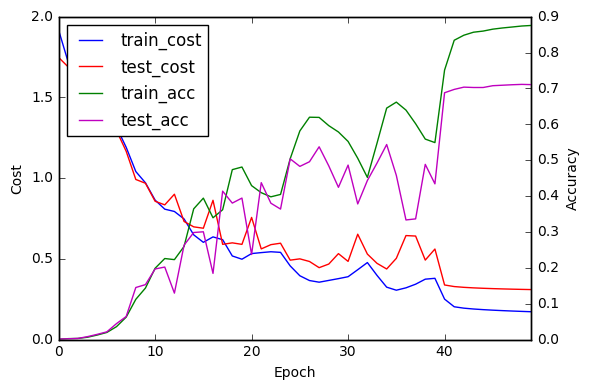

In [31]:
total_epoch = 50
fig, ax1 = plt.subplots()
lns1 = ax1.plot(range(total_epoch), autoencoder.cost, label='train_cost', color='b')
lns2 = ax1.plot(range(total_epoch), autoencoder.val_cost, label='test_cost', color='r')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Cost')
ax1.set_xticks(range(0,total_epoch+1,10))
ax2 = ax1.twinx()
lns3 = ax2.plot(range(total_epoch), autoencoder.acc, label='train_acc', color='g')
lns4 = ax2.plot(range(total_epoch), autoencoder.val_acc, label='test_acc', color='m')
ax2.set_ylabel('Accuracy')

lns = lns1 + lns2 + lns3 + lns4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=2)
fig.tight_layout()

## テストデータにおける結果の確認

テストデータのロスと精度最後に確認し、実際に足し算の結果を確認してみましょう。最後のセルを実行するたびに結果が変わるはずです。

In [32]:
autoencoder.is_traning = False
Y_pred = autoencoder.forward(X_test, Y_test)
cost = autoencoder.cost_func(Y_pred, Y_test, Y_test.shape[0]) / Y_test.shape[1]
acc = get_acc(Y_test, Y_pred)
print('val_cost: {:.3}, val_acc: {:.3}'.format(cost, acc))

val_cost: 0.309, val_acc: 0.711


In [33]:
x_test = ''
y_test = ''
y_pred_test  = ''
num = np.random.randint(len(Y_test)-1)
for x in X_test[num]:
    x_test += ix2char[np.argmax(x)]
for y, y_pred in zip(Y_test[num], Y_pred[num]):
    y_test += ix2char[np.argmax(y)]
    y_pred_test += ix2char[np.argmax(y_pred)]
print('input:{}, output:{}, predict:{}'.format(x_test, y_test, y_pred_test))

input:807+430, output:1237, predict:1237
